In [68]:
import numpy as np
import matplotlib.pyplot as plt
from utils import uniform_shell_sampler, make_nice_plots, fast_z_at_value
from scipy import stats
from tqdm import tqdm
from scipy.special import erf
from default_arguments import DEFAULT_COSMOLOGY
import astropy.units as u
from scipy.integrate import quad
from scipy.stats import gaussian_kde

make_nice_plots()


#### Now we are increasing the complexity by using comoving distances, luminosity distances and redshifts

/var/tmp/pouw/ipykernel_3054770/4257014349.py:24: RuntimeWarning: divide by zero encountered in divide
  return 0.5 * (1 + erf( (r_thresh - r) / (np.sqrt(2) * r_err * r)) )
/var/tmp/pouw/ipykernel_3054770/4257014349.py:63: RuntimeWarning: invalid value encountered in scalar divide
  empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true


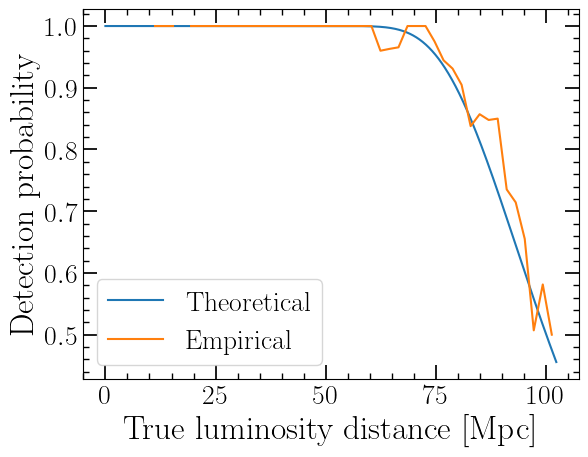

Detection probability: 1
Detected: 500 from AGN and 500 from ALT.


In [ ]:
####################################################################
USE_GW_SELECTION_EFFECTS = False
GW_DIST_ERR = 0.2  # Relative error
COMDIST_MIN = 0
COMDIST_MAX = 100  # Maximum comoving distance in Mpc
LUMDIST_THRESH_GW = 100  # Luminosity distance threshold in Mpc
NAGN = int(1e2)
NGW_ALT = int(5e2)
NGW_AGN = int(5e2)
N_POST_SAMPS = int(1e3)
N_MC_SAMPS = int(1e4)
rr = np.linspace(COMDIST_MIN, COMDIST_MAX, 1000)
CHUNK = int(100)

COSMO = DEFAULT_COSMOLOGY
ZMIN = 0
ZMAX = fast_z_at_value(COSMO.comoving_distance, COMDIST_MAX * u.Mpc)
LUMDIST_MIN = COSMO.luminosity_distance(ZMIN).value
LUMDIST_MAX = COSMO.luminosity_distance(ZMAX).value
####################################################################


def detection_prob(r, r_thresh, r_err):
    return 0.5 * (1 + erf( (r_thresh - r) / (np.sqrt(2) * r_err * r)) )


# AGN catalog
agn_rcom, _, _ = uniform_shell_sampler(COMDIST_MIN, COMDIST_MAX, NAGN)  # NO AGN NEEDED ABOVE RMAX_GW, p_rate = 0
agn_z = fast_z_at_value(COSMO.comoving_distance, agn_rcom * u.Mpc)
agn_rlum = COSMO.luminosity_distance(agn_z).value

# GWs & likelihood
# GENERATE GWS UP TO RMAX_GW
true_rcom_gw_alt, _, _ = uniform_shell_sampler(COMDIST_MIN, COMDIST_MAX, NGW_ALT)
true_rcom_gw_agn = np.random.choice(agn_rcom, NGW_AGN)
true_rcom_all = np.append(true_rcom_gw_agn, true_rcom_gw_alt)

true_z_gw_alt = fast_z_at_value(COSMO.comoving_distance, true_rcom_gw_alt * u.Mpc)
true_z_gw_agn = fast_z_at_value(COSMO.comoving_distance, true_rcom_gw_agn * u.Mpc)
true_z_all = fast_z_at_value(COSMO.comoving_distance, true_rcom_all * u.Mpc)

true_rlum_gw_alt = COSMO.luminosity_distance(true_z_gw_alt).value
true_rlum_gw_agn = COSMO.luminosity_distance(true_z_gw_agn).value
true_rlum_all = COSMO.luminosity_distance(true_z_all).value

# MEASURE
obs_rlum_gw_alt = true_rlum_gw_alt * (1. + GW_DIST_ERR * np.random.normal(size=NGW_ALT))
obs_rlum_gw_agn = true_rlum_gw_agn * (1. + GW_DIST_ERR * np.random.normal(size=NGW_AGN))
obs_rlum_all = np.append(obs_rlum_gw_agn, obs_rlum_gw_alt)


### CHECK IF DETECTION PROB IS CORRECT ###
xx = np.linspace(0, LUMDIST_MAX, 1000)
plt.figure()
plt.plot(xx, detection_prob(xx, LUMDIST_THRESH_GW, GW_DIST_ERR), label='Theoretical')
edges = np.linspace(0, LUMDIST_MAX, 51)
empericial_detection_prob = np.zeros(len(edges) - 1)
for i in range(len(edges) - 1):
    selec = (true_rlum_all > edges[i]) & (true_rlum_all < edges[i + 1])
    data_in_bin = obs_rlum_all[selec]
    n_gws_in_bin_true = len(data_in_bin)
    n_gws_in_bin_obs = np.sum(data_in_bin < LUMDIST_THRESH_GW)
    empericial_detection_prob[i] = n_gws_in_bin_obs / n_gws_in_bin_true
plt.plot(edges[:-1] + np.diff(edges)[0] * 0.5, empericial_detection_prob, label='Empirical')
plt.xlabel('True luminosity distance [Mpc]')
plt.ylabel('Detection probability')
plt.legend()
plt.show()
###########################################


if USE_GW_SELECTION_EFFECTS:
    # ONLY KEEP EVENTS WITH OBSERVED DISTANCES BELOW THRESHOLD
    obs_rlum_gw_alt = obs_rlum_gw_alt[obs_rlum_gw_alt < LUMDIST_THRESH_GW]
    obs_rlum_gw_agn = obs_rlum_gw_agn[obs_rlum_gw_agn < LUMDIST_THRESH_GW]
    obs_rlum_all = np.append(obs_rlum_gw_agn, obs_rlum_gw_alt)
    p_det = np.sum( detection_prob(agn_rlum, LUMDIST_THRESH_GW, GW_DIST_ERR) ) / len(agn_rlum)
else:
    p_det = 1

print(f'Detection probability: {p_det}')
print(f'Detected: {len(obs_rlum_gw_agn)} from AGN and {len(obs_rlum_gw_agn)} from ALT.')



In [70]:
def dVdz_unnorm(z, cosmo):
    '''Assuming flat LCDM'''
    Omega_m = cosmo.Om0
    Omega_Lambda = 1 - Omega_m
    E_of_z = np.sqrt((1 + z)**3 * Omega_m + Omega_Lambda)
    com_vol = ((1 + z) * cosmo.angular_diameter_distance(z).value)**2 / E_of_z
    return com_vol

func = lambda z: dVdz_unnorm(z, COSMO)
NORM = quad(func, ZMIN, ZMAX)[0]  # NORMALIZE UP TO ZMAX, since p_rate(z > ZMAX) = 0

def dVdz_prior(z, norm=NORM, cosmo=COSMO):
    return dVdz_unnorm(z, cosmo) / norm


In [71]:
def generate_posterior(rlum_obs, rlum_relerr=GW_DIST_ERR, n_posterior_samples=N_POST_SAMPS):
    # Importance resampling of distances
    dtrue_postsamps = rlum_obs / (1 + rlum_relerr * np.random.normal(size=4 * n_posterior_samples))
    neg = dtrue_postsamps < 0
    if np.sum(neg) != 0:
        print(f'Removing {np.sum(neg)} negative luminosity distance samples.')
    dtrue_postsamps = dtrue_postsamps[~neg]  # WARNING: Negative values are very rare, (currently tested with 20% error, get only 1 negative sample sometimes), so just remove them. But be aware!
    weights = dtrue_postsamps / np.sum(dtrue_postsamps)  # Importance weights proportional to d
    lumdist_samples = np.random.choice(dtrue_postsamps, size=2 * n_posterior_samples, p=weights)
    
    # Redshift reweighting
    z_samples = fast_z_at_value(COSMO.luminosity_distance, lumdist_samples * u.Mpc)
    H_z = COSMO.H(z_samples).value  # H(z) in km/s/Mpc
    chi_z = COSMO.comoving_distance(z_samples).value  # in Mpc
    dDL_dz = chi_z + (1 + z_samples) * (3e5 / H_z)  # c = 3e5 km/s, TODO: change to astropy.const
    z_weights = 1 / dDL_dz
    z_weights /= np.sum(z_weights)
    z_samples = np.random.choice(z_samples, n_posterior_samples, p=z_weights)
    return z_samples


def gw_processing(rlum_obs, agn_z, n_mc_samps=N_MC_SAMPS):
    Ngw = len(rlum_obs)
    p_agn = np.zeros(Ngw)
    p_alt = np.zeros(Ngw)
    kdes = []
    for i, obs in tqdm(enumerate(rlum_obs), total=Ngw):
        gw_z_posterior = generate_posterior(obs)
        kde_gw_z_posterior = gaussian_kde(gw_z_posterior)
        p_agn[i] = np.sum(kde_gw_z_posterior(agn_z)) / len(agn_z)
        
        idx_array = np.random.choice(np.arange(len(gw_z_posterior)), size=n_mc_samps)
        mc_redshift = gw_z_posterior[idx_array]
        p_alt[i] = np.sum( dVdz_prior(mc_redshift), axis=0) / n_mc_samps

        kdes.append(kde_gw_z_posterior)
    return p_agn, p_alt, kdes


def gw_processing_thread(index, rlum_obs, agn_z, n_mc_samps=N_MC_SAMPS):
    gw_z_posterior = generate_posterior(rlum_obs)
    kde_gw_z_posterior = gaussian_kde(gw_z_posterior)
    p_agn = np.sum(kde_gw_z_posterior(agn_z)) / len(agn_z)
    
    idx_array = np.random.choice(np.arange(len(gw_z_posterior)), size=n_mc_samps)
    mc_redshift = gw_z_posterior[idx_array]
    p_alt = np.sum( dVdz_prior(mc_redshift), axis=0) / n_mc_samps
    return index, p_agn, p_alt


In [72]:
p_agn_agn_gws, p_alt_agn_gws, kdes_agn_gw = gw_processing(obs_rlum_gw_agn, agn_z)
p_agn_alt_gws, p_alt_alt_gws, kdes_alt_gw = gw_processing(obs_rlum_gw_alt, agn_z)

100%|██████████| 500/500 [01:00<00:00,  8.33it/s]


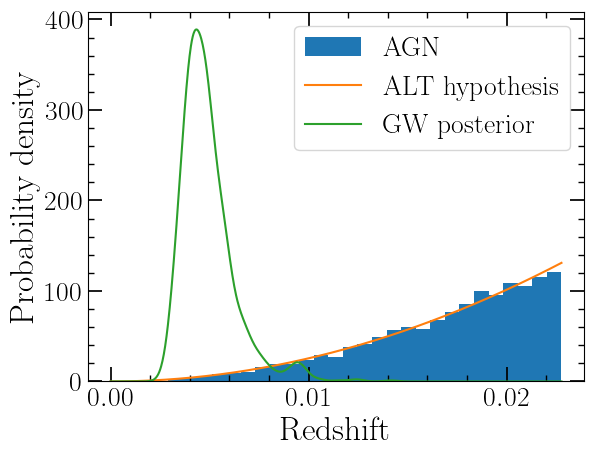

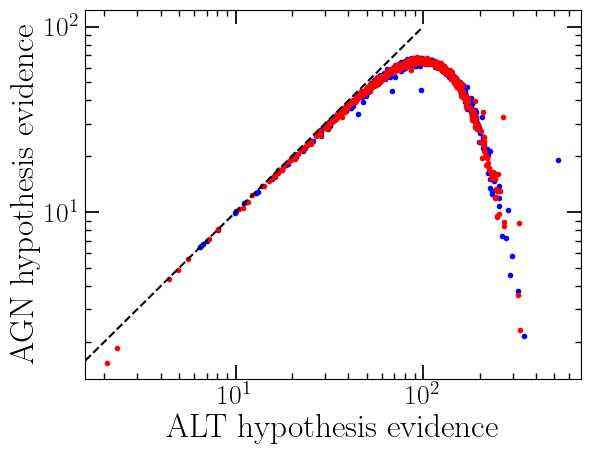

In [73]:
zz = np.linspace(ZMIN, ZMAX, 1000)

plt.figure()
plt.hist(agn_z, bins=30, density=True, label='AGN')
plt.plot(zz, dVdz_prior(zz), label='ALT hypothesis')
plt.plot(zz, kdes_agn_gw[0](zz), label='GW posterior')
plt.legend()
plt.xlabel('Redshift')
plt.ylabel('Probability density')
plt.show()

plt.figure()
plt.scatter(p_alt_agn_gws, p_agn_agn_gws, color='blue', marker='.')
plt.scatter(p_alt_alt_gws, p_agn_alt_gws, color='red', marker='.')
plt.plot(np.linspace(0, 100, 10), np.linspace(0, 100, 10), color='black', linestyle='dashed')
plt.loglog()
plt.xlabel('ALT hypothesis evidence')
plt.ylabel('AGN hypothesis evidence')
plt.show()


In [ ]:
# from concurrent.futures import as_completed, ThreadPoolExecutor, ProcessPoolExecutor
# from multiprocessing import cpu_count

In [75]:
# n_agn_gw = len(obs_rlum_gw_agn)
# p_agn_agn_gws = np.zeros(n_agn_gw)
# p_alt_agn_gws = np.zeros(n_agn_gw)
# with ProcessPoolExecutor(max_workers=cpu_count()) as executor:
#     future_to_index = {executor.submit(
#                                     gw_processing_thread, 
#                                     index, 
#                                     obs_rlum,
#                                     agn_z
#                                 ): index for index, obs_rlum in enumerate(obs_rlum_gw_agn)
#                                 }
    
#     for future in tqdm(as_completed(future_to_index), total=n_agn_gw):
#         try:
#             i, p_agn_agn_gws[i], p_alt_agn_gws[i] = future.result(timeout=20)
#         except Exception as e:
#             print(f"Error processing event {future_to_index[future]}: {e}")


In [76]:
# n_alt_gw = len(obs_rlum_gw_alt)
# p_agn_alt_gws = np.zeros(n_alt_gw)
# p_alt_alt_gws = np.zeros(n_alt_gw)
# with ThreadPoolExecutor(max_workers=cpu_count()) as executor:
#     future_to_index = {executor.submit(
#                                     gw_processing_thread, 
#                                     index, 
#                                     obs_rlum,
#                                     agn_z
#                                 ): index for index, obs_rlum in enumerate(obs_rlum_gw_alt)
#                                 }
    
#     for future in tqdm(as_completed(future_to_index), total=n_alt_gw):
#         try:
#             i, p_agn_alt_gws[i], p_alt_alt_gws[i] = future.result(timeout=20)
#         except Exception as e:
#             print(f"Error processing event {future_to_index[future]}: {e}")

100%|██████████| 100/100 [00:07<00:00, 13.03it/s]


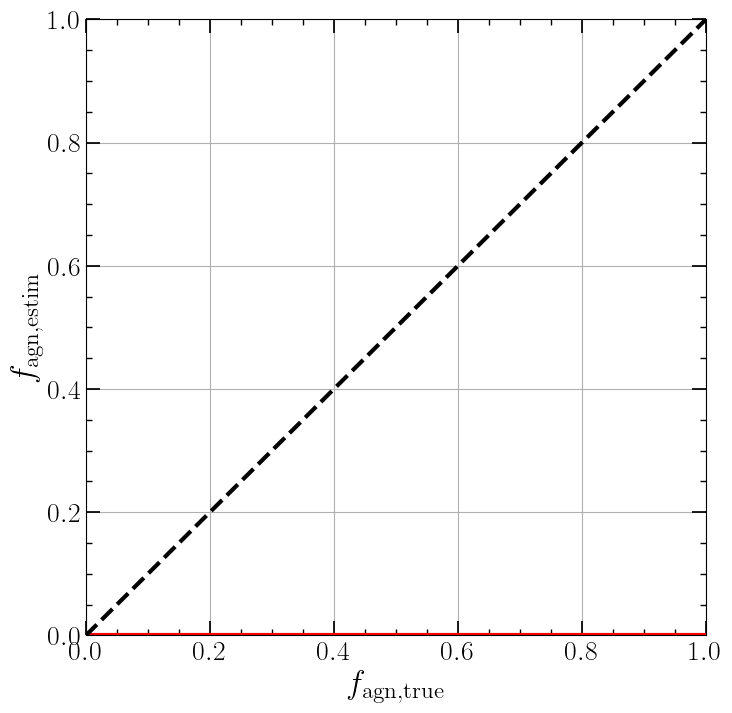

In [77]:
### Some translations to reuse my code ###
cw_pagn = np.append(p_agn_agn_gws, p_agn_alt_gws)
cw_palt = np.append(p_alt_agn_gws, p_alt_alt_gws)
palt = cw_palt  # c = 1
agn_events = np.ones(int(len(obs_rlum_gw_agn) + len(obs_rlum_gw_alt)), dtype=bool)
agn_events[len(obs_rlum_gw_agn):] = 0
alt_events = ~agn_events
##########################################

use_N_gws = 100
max_N_fagns = 51
N_true_fagns = min(use_N_gws+1, max_N_fagns)    # Cannot create more f_agn values than use_N_gws+1 and don't want to generate more than max_N_fagns
calc_logllh_at_N_points = 1000                  # Only change if you want higher resolution, but why would you?
log_llh_x_ax = np.linspace(0.0001, 0.9999, calc_logllh_at_N_points)
n_trials = 100
gw_chunk_size = 100  # Optimized for my own system - vectorize operations for this many GWs 
llh_chunk_size = 10  # Optimized for my own system - vectorize operations for this many values of f_agn

if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):
    print('Chunking...')

estimation_arr = np.zeros((n_trials, N_true_fagns))
for trial_idx in tqdm(range(n_trials)):
    ## These two lines are for making the underlying truth equal to the actual realization of that truth
    # use_N_agn_events = np.arange(0, use_N_gws + 1, int(use_N_gws / (N_true_fagns-1)), dtype=np.int32)
    # true_fagns = use_N_agn_events / use_N_gws
    
    ## Otherwise, use these two
    true_fagns = np.linspace(0, 1, N_true_fagns)  # Underlying truth
    use_N_agn_events = np.random.binomial(n=use_N_gws, p=true_fagns)  # Make random realization of a universe with a true fagn

    use_N_alt_events = use_N_gws - use_N_agn_events
    realized_fagns = use_N_agn_events / use_N_gws  # Realization of the truth

    agn_idx = np.random.choice(np.where(agn_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    alt_idx = np.random.choice(np.where(alt_events)[0], size=(N_true_fagns, use_N_gws), replace=True)
    idx = np.where(np.arange(use_N_gws) < use_N_agn_events[:, None], agn_idx, alt_idx)  # Shape (N_true_fagns, use_N_gws)

    fagn_times_fobsc = log_llh_x_ax[:, np.newaxis, np.newaxis]
    total_cw_prob_agn = cw_pagn[idx].T[np.newaxis,...]
    total_cw_prob_alt = cw_palt[idx].T[np.newaxis,...]
    total_prob_alt = palt[idx].T[np.newaxis,...]

    if (use_N_gws > gw_chunk_size) & (calc_logllh_at_N_points > llh_chunk_size):  # Chunking to avoid too large arrays in memory

        log_llh_numerator = np.zeros((calc_logllh_at_N_points, N_true_fagns))
        for i in range(int(use_N_gws / gw_chunk_size)):
            gw_start, gw_stop = int(i * gw_chunk_size), int((i + 1) * gw_chunk_size)
            cw_agn_prob_chunk = total_cw_prob_agn[:, gw_start:gw_stop, :]
            cw_alt_prob_chunk = total_cw_prob_alt[:, gw_start:gw_stop, :]
            alt_prob_chunk = total_prob_alt[:, gw_start:gw_stop, :]

            for j in range(int(calc_logllh_at_N_points / llh_chunk_size)):
                llh_start, llh_stop = int(j * llh_chunk_size), int((j + 1) * llh_chunk_size)
                fagn_chunk = fagn_times_fobsc[llh_start:llh_stop, ...]
                fagn_times_cw_p_agn = fagn_chunk * cw_agn_prob_chunk
                fagn_times_cw_p_alt = fagn_chunk * cw_alt_prob_chunk
                alt_prob_chunk_rightshape = np.ones_like(fagn_chunk) * alt_prob_chunk  # TODO: This shape correction doesn't seem to matter

                log_prob = np.log(fagn_times_cw_p_agn + alt_prob_chunk_rightshape - fagn_times_cw_p_alt)
                log_llh_numerator[llh_start:llh_stop, :] += np.sum(log_prob, axis=1)
    else:
        log_llh_numerator_per_event = np.log(fagn_times_fobsc * total_cw_prob_agn + total_prob_alt - fagn_times_fobsc * total_cw_prob_alt)
        log_llh_numerator = np.sum(log_llh_numerator_per_event, axis=1 )

    log_llh_denominator = use_N_gws * np.log(p_det)  # TODO: PROPERLY DO GW SELECTION EFFECTS
    log_llh = log_llh_numerator - log_llh_denominator
    estimation_arr[trial_idx, :] = log_llh_x_ax[np.argmax(log_llh, axis=0)]  # TODO: change to interpolation

fagn_medians = np.median(estimation_arr, axis=0)
q016 = np.quantile(estimation_arr, 0.16, axis=0)
q084 = np.quantile(estimation_arr, 0.84, axis=0)

plt.figure(figsize=(8,8))
plt.plot(true_fagns, fagn_medians, color='red', linewidth=3)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle='dashed', color='black', zorder=6, linewidth=3)
plt.fill_between(true_fagns, q016, q084, color='red', alpha=0.3)
plt.xlabel(r'$f_{\rm agn, true}$')
plt.ylabel(r'$f_{\rm agn, estim}$')
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()
